# <font color="green">使用``Gluon``识别ImageNet子集 - 120种狗

<img src="../img/Chapter8-Computer-Vision/8-2.png" width="1000">

比赛地址：[Dog Breed Identification](https://www.kaggle.com/c/dog-breed-identification)

** 学会使用kaggle官方工具下载数据集：**

github地址： https://github.com/Angzz/kaggle-api
* 1.pip install kaggle
* 2.在kaggle个人用户界面授权获得API文件 - kaggle.json
* 3.将kaggle.json上传至/home/<username>/.kaggle目录下
* 4.授权访问： chmod 600 /home/liang/.kaggle/kaggle.json
* 5.下载数据集：kaggle competitions download -c favorita-grocery-sales-forecasting -f test.csv.7z

In [20]:
import mxnet as mx
import numpy as np
import pandas as pd

import utils

from mxnet import nd
from mxnet import gluon
from mxnet import autograd
from mxnet import image
from mxnet import lr_scheduler

from tqdm import tqdm

%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
import matplotlib.pyplot as plt

mx.random.seed(2018)

## 解压数据文件

In [21]:
data_dir = "data/kaggle_dog"
train_file = 'train.zip'
test_file = 'test.zip'
label_file = 'labels.csv.zip'

zipfiles = [train_file, test_file, label_file]
import os
import zipfile

# just execute once 
if not os.path.exists(data_dir+'/'+'train') and not os.path.exists(data_dir+'/'+'test'):
    for file in zipfiles:
        with zipfile.ZipFile(data_dir + '/' + file, 'r') as zin:
            zin.extractall(data_dir)

## 整理数据集

In [22]:
from collections import Counter
# Python内置模块Counter计数器的使用
s = '''A Counter is a dict subclass for counting hashable objects. It is an unordered collection where elements 
are stored as dictionary keys and their counts are stored as dictionary values. Counts are allowed to be any 
integer value including zero or negative counts. The Counter class is similar to bags or multisets in other 
languages.'''.lower()

c = Counter(s)
c.most_common

<bound method Counter.most_common of Counter({' ': 54, 'e': 32, 's': 25, 'a': 24, 't': 24, 'o': 22, 'n': 21, 'r': 20, 'i': 20, 'c': 15, 'l': 14, 'u': 13, 'd': 10, 'g': 7, 'h': 6, 'b': 5, '.': 4, 'y': 4, 'm': 3, '\n': 3, 'v': 3, 'w': 2, 'f': 1, 'j': 1, 'k': 1, 'z': 1})>

In [23]:
import math
import shutil
from collections import Counter

def reorg_dog_files(data_dir, label_file, train_dir, test_dir, input_dir, valid_ratio):
    # 整理label
    with open(os.path.join(data_dir, label_file)) as f:
        lines = f.readlines()[1:]
        tokens = [l.rstrip().split(',') for l in lines]
        # use generator to generate the dictionary
        idx_label = dict(((idx, label) for idx, label in tokens))
        labels = set(idx_label.values())
    
    # 训练集的数量
    num_train = len(os.listdir(os.path.join(data_dir, train_dir)))
    # 训练集中数量最少的狗品种
    min_num_train_per_label = Counter(idx_label.values()).most_common()[::-1][0][1]
    # 设置验证集中每一类狗的数量
    num_valid_per_label = math.floor(min_num_train_per_label * valid_ratio)
    
    def make_dir_if_not_exist(path):
        if not os.path.exists(os.path.join(*path)):
            os.makedirs(os.path.join(*path))
    
    label_count = {}
    # 整理训练和验证集
    for train_file in os.listdir(os.path.join(data_dir, train_dir)):
        idx = train_file.split('.')[0]
        label = idx_label[idx]
        make_dir_if_not_exist([data_dir, input_dir, 'train_valid', label])
        shutil.copy(os.path.join(data_dir, train_dir, train_file), 
                   os.path.join(data_dir, input_dir, 'train_valid', label))
        if label not in label_count or label_count[label] < num_valid_per_label:
            make_dir_if_not_exist([data_dir, input_dir, 'valid', label])
            shutil.copy(os.path.join(data_dir, train_dir, train_file),
                       os.path.join(data_dir, input_dir, 'valid', label))
            label_count[label] = label_count.get(label, 0) + 1
        else:
            make_dir_if_not_exist([data_dir, input_dir, 'train', label])
            shutil.copy(os.path.join(data_dir, train_dir, train_file),
                       os.path.join(data_dir, input_dir, 'train', label))
    
    # 整理测试集
    for test_file in os.listdir(os.path.join(data_dir, test_dir)):
        make_dir_if_not_exist([data_dir, input_dir, 'test', 'unknown'])
        shutil.copy(os.path.join(data_dir, test_dir, test_file),
                   os.path.join(data_dir, input_dir, 'test', 'unknown'))

In [24]:
unzipfiles = [zip.split('.')[0] for zip in zipfiles[:-1]]
unzipfiles.append('labels.csv')

data_dir = 'data/kaggle_dog'
input_dir = 'train_valid_test'
train_dir, test_dir, label_file = unzipfiles
valid_ratio = 0.1
valid_dir = 'valid'
train_valid_dir = 'train_valid'

model_features_dir = 'model_features'
nd_data_dir = 'nd_data'

if not os.path.exists(os.path.join(data_dir, input_dir, test_dir)):
    reorg_dog_files(data_dir, label_file=label_file, train_dir=train_dir, test_dir=test_dir, 
                    input_dir=input_dir, valid_ratio=0.1)

## 使用``Gluon``读取数据集

In [25]:
def apply_aug_list(img, augs):
    for aug in augs:
        img = aug(img)
    return aug

def get_transform(augs):
    def transform(data, label):
        data = data.astype(np.float32)
        for aug in augs:
            data = aug(data)
        # 是否使用clip有待商榷
        data = data.transpose((2,0,1)) / 255
        return data, nd.array([label]).asscalar().astype(np.float32)
    return transform

input_str = data_dir + '/' + input_dir + '/'

# Load to DataLoader
def get_data(inceptionv3=False, batch_size=64, get_ds=False):
    resize = 299 if inceptionv3 else 224
    train_augs = [
        image.ForceResizeAug((resize, resize)),
        image.ColorNormalizeAug(mean=nd.array([0.485, 0.456, 0.406]), std=nd.array([0.229, 0.224, 0.225]))
    ]

    test_augs = [
        image.ForceResizeAug((resize, resize)),
        image.ColorNormalizeAug(mean=nd.array([0.485, 0.456, 0.406]),
                               std=nd.array([0.229, 0.224, 0.225]))
    ]
    
    train_ds = gluon.data.vision.ImageFolderDataset(input_str + train_dir, transform=get_transform(train_augs))
    valid_ds = gluon.data.vision.ImageFolderDataset(input_str + valid_dir, transform=get_transform(test_augs))
    train_valid_ds = gluon.data.vision.ImageFolderDataset(input_str + train_valid_dir, transform=get_transform(train_augs))
    test_ds = gluon.data.vision.ImageFolderDataset(input_str + test_dir, transform=get_transform(test_augs))
    if get_ds:
        return train_ds, valid_ds, train_valid_ds, test_ds
    train_data = gluon.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, last_batch='keep')
    valid_data = gluon.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=True, last_batch='keep')
    train_valid_data = gluon.data.DataLoader(train_valid_ds, batch_size=batch_size, shuffle=True, last_batch='keep')
    test_data = gluon.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False, last_batch='keep')
    return train_data, valid_data, train_valid_data, test_data

## 画出图片

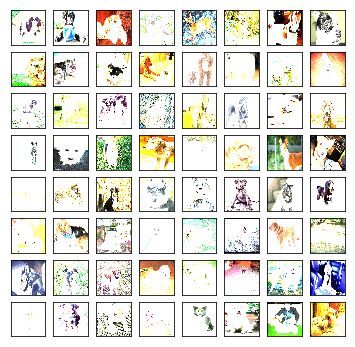

In [7]:
train_data, _, _, _ = get_data(inceptionv3=False)
for img, _ in train_data:
    img = img.as_in_context(mx.cpu())
    break
utils.show_images(img.transpose((0,2,3,1)), nrows=8, ncols=8, figsize=(6,6))

## 使用预训练模型进行迁移学习

使用迁移学习的好处是：由于在ImageNet上训练过的模型具有很强的模型泛化能力，因此我们可以用预训练的模型来解决新的任务，一般的做法是，我们固定模型的feature层，将所有数据划分后过一遍feature层并保存模型特征，最后使用一个全连接的网络对预训练模型的输出进行分类，这样既保留了ImageNet上模型强大的表达能力，又可以节约计算资源，因为我们仅需要将模型过一遍全连接层，而预训练阶段因为没有反向传播过程，因此很快就可以由输入得到输出。

###  保存数据标签至本地
* 注意数据顺序只能如下，不能变

In [49]:
# 将特征保存到本地之后就不需要再初始化数据了
train_data_224, valid_data_224, _, _ = get_data(inceptionv3=False, get_ds=True)
train_data_299, valid_data_299, _, _ = get_data(inceptionv3=True, get_ds=True)

batch_size = 32
# 这边不shuffle的原因是为了保持生成的224尺寸的数据和299尺寸的数据顺序是相同的
train_iter_224 = gluon.data.DataLoader(train_data_224, batch_size=batch_size, shuffle=False, last_batch='keep')
train_iter_299 = gluon.data.DataLoader(train_data_299, batch_size=batch_size, shuffle=False, last_batch='keep')
valid_iter_224 = gluon.data.DataLoader(valid_data_224, batch_size=batch_size, shuffle=False, last_batch='keep')
valid_iter_299 = gluon.data.DataLoader(valid_data_299, batch_size=batch_size, shuffle=False, last_batch='keep')

### 定义保存所有预训练模型特征的函数并导出所有预训练模型的特征

In [26]:
from mxnet.gluon.model_zoo import vision as models

ctx_list = [mx.gpu()]

# 保存预训练模型的features到本地
def save_features(model_name, train_iter, valid_iter, ignore=False):
    # 判断features是否已存在
    if not os.path.exists(os.path.join(data_dir, model_features_dir)):
        os.mkdir(os.path.join(data_dir, model_features_dir)) 
    if os.path.exists(os.path.join(data_dir, model_features_dir, 'features_train_{}.nd'.format(model_name))) and ignore:
        if os.path.exists(os.path.join(data_dir, model_features_dir, 'features_test_{}.nd'.format(model_name))):
            return 
        
    print('--------------------%s--------------------' % (model_name))
    net = models.get_model(model_name, pretrained=True, ctx=ctx_list)
    global_avg_pool = gluon.nn.GlobalAvgPool2D()
    flatten = gluon.nn.Flatten()
    for prefix, data_iter in zip(['train', 'valid'], [train_iter, valid_iter]):
        features = []
        labels = []
        for data, label in tqdm(data_iter):
            # 使用split_and_load进行多设备预测
            data_batch = gluon.utils.split_and_load(data, ctx_list=ctx_list, even_split=False)
            for data_slice in data_batch:
                feature = net.features(data_slice)
                if 'squeezenet' in model_name:
                    feature = global_avg_pool(feature)
                # 这地方到底要不要加flatten有待商榷
                feature = flatten(feature)
                # 将所有特征都保存到cpu
                features.append(feature.as_in_context(mx.cpu()))      
            nd.waitall()
            labels.append(label)
        features = nd.concat(*features, dim=0)
        labels = nd.concat(*labels, dim=0)
        nd.save(os.path.join(data_dir, model_features_dir, 'features_{}_{}.nd'.format(prefix, model_name)), [features, labels])

### 加载预训练模型并保存所有模型特征

In [ ]:
from mxnet.gluon.model_zoo.model_store import _model_sha1

# 保存所有模型的特征
# for model in sorted(_model_sha1.keys()):
#     print(model)
model = 'resnet152_v1'
if model == 'inceptionv3':
    save_features(model, train_iter_299, valid_iter_299, ignore=True)
else:
    save_features(model, train_iter_224, valid_iter_224, ignore=True)

### 使用所有导出的特征进行训练，并比较模型性能，挑选出最佳模型进行Ensemble
* 即选出valid_loss最小的前n个网络进行训练

#### 定义输出网络

In [28]:
num_classes = 120

def output_model(ctx):
    output = gluon.nn.HybridSequential()
    with output.name_scope():
        output.add(
            gluon.nn.Dense(256),
            gluon.nn.Activation('relu'),
            gluon.nn.Dropout(rate=.5),
            gluon.nn.Dense(num_classes)
        )
    output.collect_params().initialize(ctx=ctx, init=mx.init.Xavier(rnd_type='gaussian', factor_type='in', magnitude=2.))
    output.hybridize()
    return output

#### 从本地加载预训练模型输出的特征，划分训练集和验证集

In [29]:
def load_traindata_from_pretrained_models(model_name, inceptionv3=False, batch_size=128):
    train_feature_label = nd.load(os.path.join(data_dir,  model_features_dir, 'features_train_{}.nd'.format(model_name)))
    valid_feature_label = nd.load(os.path.join(data_dir,  model_features_dir, 'features_valid_{}.nd'.format(model_name)))
    train_len = int(train_feature_label[0].shape[0])
    valid_len = int(valid_feature_label[0].shape[0])
    train_iter = gluon.data.DataLoader(gluon.data.ArrayDataset(train_feature_label[0], train_feature_label[1]),
                                       batch_size=batch_size, shuffle=True, last_batch='keep')
    valid_iter = gluon.data.DataLoader(gluon.data.ArrayDataset(valid_feature_label[0], valid_feature_label[1]),
                                       batch_size=batch_size, shuffle=False, last_batch='keep')
    return train_iter, valid_iter

#### 训练预训练模型进行性能评估，并按照valid_loss排序

In [57]:
from time import time
    
def train_pretrained_models(model_name, epochs=50, batch_size=128, learning_rate=1e-4, wd=1e-5, ctx=mx.gpu()):
    train_iter, valid_iter = load_traindata_from_pretrained_models(model_name, batch_size)
    net = output_model(ctx)
    trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': learning_rate, 'wd': wd})
    softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
    
    moving_loss = .0
    smooth_const = .9
    niter = 0
    
    print('--------------------%s--------------------' % (model_name))
    for epoch in range(epochs):
        start = time()
        for i, (data, label) in enumerate(train_iter):
            data = data.as_in_context(ctx)
            label = label.as_in_context(ctx)
            with autograd.record():
                output = net(data)
                loss = softmax_cross_entropy(output, label)
            loss.backward()
            trainer.step(batch_size)
            
            niter += 1
            curr_loss = nd.mean(loss).asscalar()
            moving_loss = smooth_const * moving_loss + (1-smooth_const) *  curr_loss
            estimated_loss = moving_loss / (1 - smooth_const**niter)
            
        train_acc, train_loss = utils.evaluate_accuracy_gluon(train_iter, net, ctx, loss_avg=True)
        valid_acc, valid_loss = utils.evaluate_accuracy_gluon(valid_iter, net, ctx, loss_avg=True)
            
        if not (epoch+1) % 5:
            print("[Epoch %d] Moving Train Loss %.5f, Train Acc %.5f, Valid Loss %.5f, Valid Acc %.5f, Time Consume %.5f s."
                 % (epoch+1, estimated_loss, train_acc, valid_loss, valid_acc, time()-start))
    return valid_loss

In [ ]:
ctx = mx.gpu()
valid_losses = {}
# for model_name in sorted(_model_sha1.keys()):
model_name = 'inceptionv3'
final_valid_loss = train_pretrained_models(model_name)
valid_losses[model_name] = final_valid_loss

In [31]:
valid_losses

{'inceptionv3': 0.8482408026854198}

In [15]:
# df = pd.DataFrame(valid_losses, columns=['model', 'val_loss'])
# df = df.sort_values('val_loss')
# df.head()

### 保存测试集的模型特征

In [32]:
resize = 224
test_augs = [
    image.ForceResizeAug((resize, resize)),
    image.ColorNormalizeAug(mean=nd.array([0.485, 0.456, 0.406]),
                           std=nd.array([0.229, 0.224, 0.225]))
]
test_batch_size = 32
test_ds_224 = gluon.data.vision.ImageFolderDataset(input_str + test_dir, transform=get_transform(test_augs))
test_data_224 = gluon.data.DataLoader(test_ds_224, batch_size=test_batch_size, shuffle=False, last_batch='keep')

In [33]:
resize = 299
test_augs = [
    image.ForceResizeAug((resize, resize)),
    image.ColorNormalizeAug(mean=nd.array([0.485, 0.456, 0.406]),
                           std=nd.array([0.229, 0.224, 0.225]))
]
test_batch_size = 32
test_ds_299 = gluon.data.vision.ImageFolderDataset(input_str + test_dir, transform=get_transform(test_augs))
test_data_299 = gluon.data.DataLoader(test_ds_299, batch_size=test_batch_size, shuffle=False, last_batch='keep')

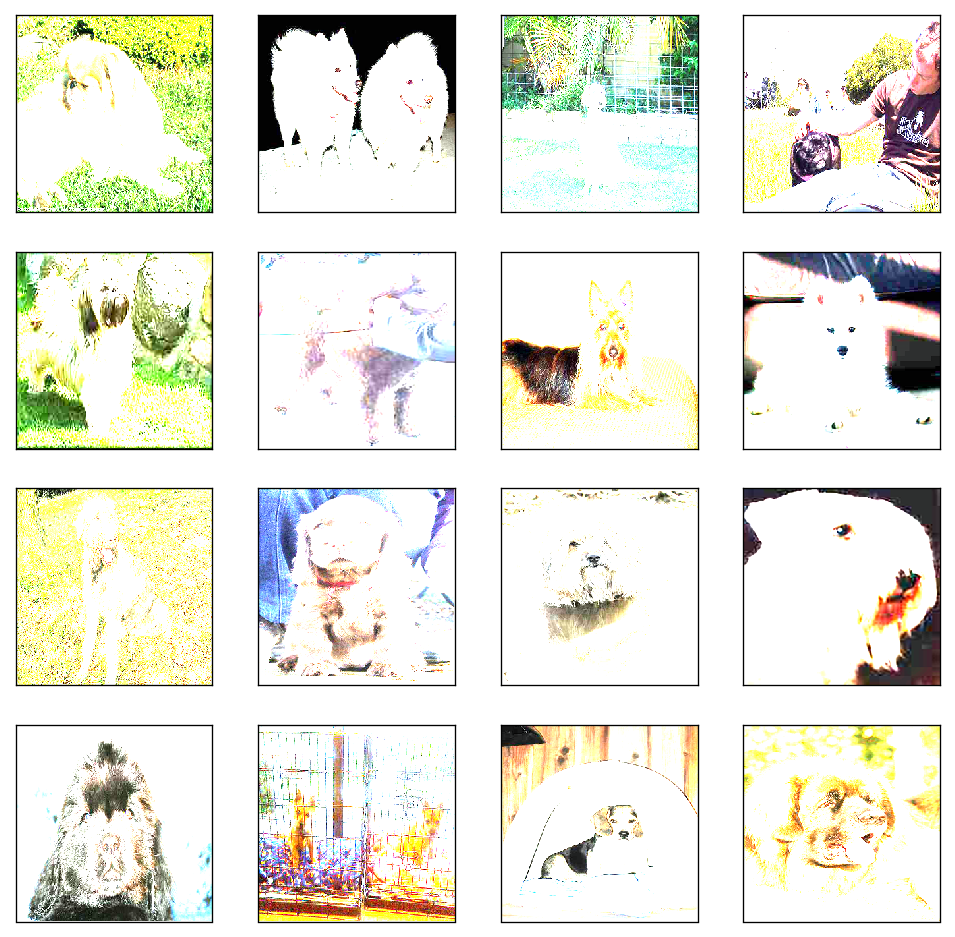

In [34]:
# 画出几张图片看看顺序
for img, _ in test_data_299:
    img = img.as_in_context(mx.cpu())
    break
utils.show_images(img.transpose((0,2,3,1)), nrows=4, ncols=4, figsize=(10,10))
# 可以看见该顺序与sample_submission.csv中的顺序是一致的

In [37]:
def save_test_features(model_name, test_iter):
    # 判断features是否存在
    if not os.path.exists(os.path.join(data_dir, model_features_dir)):
        os.mkdir(os.path.join(data_dir, model_features_dir))
    if os.path.exists(os.path.join(data_dir, model_features_dir, 'features_test_{}.nd'.format(model_name))):
        return
    print('-----------------------{}-----------------------'.format(model_name))
    net = models.get_model(model_name, pretrained=True, ctx=ctx_list)
    global_avg_pool = gluon.nn.GlobalAvgPool2D()
    flatten = gluon.nn.Flatten()
    prefix, data_iter = 'test', test_iter
    features = []
    labels = []
    for data, label in tqdm(data_iter):
        data_batch = gluon.utils.split_and_load(data, ctx_list=ctx_list, even_split=False)
        for data_slice in data_batch:
            feature = net.features(data_slice)
            if 'squeezenet' in model_name:
                feature = global_avg_pool(feature)
            feature = flatten(feature)
            features.append(feature.as_in_context(mx.cpu()))
        nd.waitall()
        labels.append(label)
    features = nd.concat(*features, dim=0)
    labels = nd.concat(*labels, dim=0)
    nd.save(os.path.join(data_dir, model_features_dir, 'features_{}_{}.nd'.format(prefix, model_name)), [features, labels])

In [38]:
# for model in sorted(_model_sha1.keys()):
model = 'inceptionv3'
if model == 'inceptionv3':
    save_test_features(model, test_data_299)
else:
    save_test_features(model, test_data_224)

### 挑选效果最好的模型进行训练

In [49]:
# ensemble所有的features
###################################  2018年3月5日
def load_traindata_from_ensemble_pretrained_models(model_names, batch_size=128):
    ensemble_train_feature_label = [nd.load(os.path.join(data_dir, model_features_dir, 'features_train_{}.nd'.format(model_name)))[0] for model_name in model_names]
    ensemble_valid_feature_label = [nd.load(os.path.join(data_dir, model_features_dir, 'features_valid_{}.nd'.format(model_name)))[0] for model_name in model_names]
    # 想想这里为什么是dim=1
    ensemble_train_feature = nd.concat(*ensemble_train_feature_label, dim=1)
    ensemble_valid_feature = nd.concat(*ensemble_valid_feature_label, dim=1)
    
    train_label = nd.load(os.path.join(data_dir, model_features_dir, 'features_train_{}.nd'.format(model_names[0])))[1]
    valid_label = nd.load(os.path.join(data_dir, model_features_dir, 'features_valid_{}.nd'.format(model_names[0])))[1]
    
    train_iter = gluon.data.DataLoader(gluon.data.ArrayDataset(ensemble_train_feature, train_label),
                                       batch_size=batch_size, shuffle=True, last_batch='keep')
    valid_iter = gluon.data.DataLoader(gluon.data.ArrayDataset(ensemble_valid_feature, valid_label),
                                       batch_size=batch_size, shuffle=False, last_batch='keep')
    return train_iter, valid_iter

In [77]:
classifier_net = output_model(ctx=mx.gpu())

def train_ensemble_pretrained_models(net, model_names, epochs=100, batch_size=128, lr=1e-4, wd=1e-5, ctx=mx.gpu()):
    train_iter, valid_iter = load_traindata_from_ensemble_pretrained_models(model_names)
    lr_sch = mx.lr_scheduler.FactorScheduler(step=400, factor=0.9)
    trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr, 'wd': wd, 'lr_scheduler': lr_sch})
    softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
    
    moving_loss = .0
    smooth_const = .9
    niter = 0
    
    print('--------------------%s--------------------' % (model_names))
    for epoch in range(epochs):
        start = time()
        for i, (data, label) in enumerate(train_iter):
            data = data.as_in_context(ctx)
            label = label.as_in_context(ctx)
            with autograd.record():
                output = net(data)
                loss = softmax_cross_entropy(output, label)
            loss.backward()
            trainer.step(batch_size)
            
            niter += 1
            curr_loss = nd.mean(loss).asscalar()
            moving_loss = smooth_const * moving_loss + (1-smooth_const) *  curr_loss
            estimated_loss = moving_loss / (1 - smooth_const**niter)
            
        train_acc, train_loss = utils.evaluate_accuracy_gluon(train_iter, net, ctx, loss_avg=True)
        valid_acc, valid_loss = utils.evaluate_accuracy_gluon(valid_iter, net, ctx, loss_avg=True)
            
        print("[Epoch %d] Moving Train Loss %.5f, Train Acc %.5f, Valid Loss %.5f, Valid Acc %.5f, Time Consume %.5f s.lr: %.5f"
                 % (epoch+1, estimated_loss, train_acc, valid_loss, valid_acc, time()-start, trainer.learning_rate))
    return valid_loss

In [78]:
model_names = ['inceptionv3', 'resnet152_v1']
train_ensemble_pretrained_models(classifier_net, model_names)

--------------------['inceptionv3', 'resnet152_v1']--------------------
[Epoch 1] Moving Train Loss 4.30859, Train Acc 0.25005, Valid Loss 4.04576, Valid Acc 0.21667, Time Consume 3.49400 s.lr: 0.00010
[Epoch 2] Moving Train Loss 3.39939, Train Acc 0.52126, Valid Loss 2.99628, Valid Acc 0.48472, Time Consume 3.59900 s.lr: 0.00010
[Epoch 3] Moving Train Loss 2.62440, Train Acc 0.65755, Valid Loss 2.18806, Valid Acc 0.60417, Time Consume 3.65000 s.lr: 0.00010
[Epoch 4] Moving Train Loss 2.28317, Train Acc 0.72511, Valid Loss 1.69752, Valid Acc 0.69028, Time Consume 2.69500 s.lr: 0.00010
[Epoch 5] Moving Train Loss 1.84289, Train Acc 0.76815, Valid Loss 1.40809, Valid Acc 0.72500, Time Consume 2.85300 s.lr: 0.00010
[Epoch 6] Moving Train Loss 1.59943, Train Acc 0.79183, Valid Loss 1.22927, Valid Acc 0.73194, Time Consume 3.08000 s.lr: 0.00009
[Epoch 7] Moving Train Loss 1.44801, Train Acc 0.80383, Valid Loss 1.14066, Valid Acc 0.75278, Time Consume 3.41800 s.lr: 0.00009
[Epoch 8] Moving T

0.6999465723832449

## 对测试集进行分类

### 载入测试集特征

In [80]:
feature_test = [nd.load(os.path.join(data_dir, model_features_dir, 'features_test_{}.nd'.format(model_name)))[0] 
                for model_name in model_names]
feature_test = nd.concat(*feature_test, dim=1)

### 利用融合的模型进行预测

In [84]:
output = nd.softmax(classifier_net(feature_test.as_in_context(mx.gpu()))).asnumpy()

### 将结果输出到csv文件进行提交

In [90]:
df_pred = pd.read_csv('sample_submission.csv')

In [89]:
for i, col_name in enumerate(df_pred.columns[1:]):
    df_pred[col_name] = output[:,i]
    
df_pred.to_csv('pred.csv', index=None)